In [1]:
import sys
import os
root_path = "/mnt/brain5/scratch/wcarvalh/projects/rljax/"
sys.path.append(root_path)
print("Started")
print(os.getcwd())

Started
/mnt/brain5/scratch/wcarvalh/projects/rljax/analysis


In [115]:
import jax
from pprint import pprint
import jax.numpy as jnp
import json

from glob import glob
from pprint import pprint
import cloudpickle

import numpy as np
import matplotlib.pyplot as plt

# from vistools.video_maker import VideoMaker
from vistools import video_tools
from projects.kitchen_gridworld import plot_tools


%load_ext autoreload
%autoreload 2
%matplotlib inline 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get File

In [3]:
def single_path(path_search):
  options = glob(path_search)
  return options[0]


basepath = 'results/kitchen_grid/final'
searches = dict(
      msf='capacity1/*msf*0.01*',
      # msf='relate_ablate4/*rel*', # model, not relational
      # usfa_lstm='baselines3/*usfa_lstm,*', # 
      # uvfa='baselines3/*r2d1*', # 
    )

directories = []
for agent, agent_search in searches.items():
    path_search = os.path.join(root_path, basepath, agent_search)
    path = single_path(path_search)

    episode_data_options = glob(os.path.join(path, "seed=*", "episode_data/data.npz"))
    episode_data = episode_data_options[0]

    config_options = glob(os.path.join(path, "seed=*", "config.json"))
    config = config_options[0]
    break

#     cuda_idx = 0
#     for seed_path in seed_paths:
#         directories.append(seed_path)

print(episode_data)
# pprint(directories)

/mnt/brain5/scratch/wcarvalh/projects/rljax/results/kitchen_grid/final/capacity1/agen=msf,sett=multiv1,task=pickup,room=5,num_=0,phi_=0.01,out_=512,lang=126,max_=30000000/seed=1/episode_data/data.npz


# Load data

In [4]:
with open(episode_data, 'rb') as f:
    data = cloudpickle.load(f)
    
with open(config, 'r') as f:
    config = json.load(f)

In [75]:
def episode_info(episode):
    def info(x):
        print(type(x))
        try:
            return x.shape
        except:
            return None
    pprint(jax.tree_map(info, episode))
        
def get_rewarding_episode(episodes):
    rewarding = []
    for episode in episodes:
        if episode['rewards'].sum() > 0:
            rewarding.append(episode)
    if rewarding:
        n = len(rewarding)
        idx = np.random.randint(n)
        return rewarding[idx]
    return None

def get_rewarding_episodes(episodes):
    rewarding = []
    for episode in episodes:
        if episode['rewards'].sum() > 0:
            rewarding.append(episode)
    return rewarding


print({k:len(v) for k, v in data.items()})
print({k:len(get_rewarding_episodes(v)) for k, v in data.items()})

episode_info(data['pickup_cleaned'][0])

{'pickup_cleaned': 27, 'slice': 37, 'pickup': 30, 'pickup_sliced': 19, 'slice2': 30, 'toggle2': 34, 'clean': 34}
{'pickup_cleaned': 27, 'slice': 36, 'pickup': 30, 'pickup_sliced': 19, 'slice2': 30, 'toggle2': 32, 'clean': 33}
<class 'numpy.ndarray'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
{'action': (41,),
 'interaction_info': [{},
                      {},
                      {},
                      {'action': None, 'object': None},
                      {},
                      {},
                      {},
                      {},
                      {},
                      {},
                      {},
                      {},
              

# Plot of SF_Q over episode

In [78]:
def get_all_qvalues(sf, w):
    multiply = jax.vmap(jnp.multiply, in_axes=(1, None), out_axes=1)
    q_values = jax.vmap(multiply)(sf, w)
    return q_values.sum(-1)

def get_chosen_qvalues(q_values, actions):
    def index(q : jnp.ndarray, a : int):
        return q[a]
    index = jax.vmap(index, in_axes=(0, None), out_axes=0)
    index = jax.vmap(index)
    return index(q_values, actions)

def get_chosen_sfs(sf_, z_idx_, action_):
    # sf [T, Z, A, D]
    # z_idx [T] 
    def index(sf : jnp.ndarray, i : int):
        return sf[i]
    index = jax.vmap(index)
    sfz = index(sf_, z_idx_)
    sfza = index(sfz, action_)
    return sfza

def get_module_sf_norms(sf_, w_, mods=4, norm='task'):
    if norm == 'task':
        q_ = sf_*w_
        # dims_per_mod = sf_.shape[-1]/mods
        q_ = jnp.stack(jnp.split(q_, mods, axis=-1), axis=1)
        return q_.sum(-1)
    elif norm == "l2":
        sf_ = jnp.stack(jnp.split(sf_, mods, axis=-1), axis=1)
        return jnp.linalg.norm(sf_, ord=2, axis=-1)
    else:
        raise RuntimeError(norm)

def get_sf_stats(episode_, config_, norm='task'):
    sf = episode_['preds'].sf # [T, Z, A, D]
    w = episode_['preds'].w # [T, D]
    actions = episode_['action'] # [T]
    # actions = jnp.ones(actions.shape, dtype=actions.dtype)*5
    stats = dict()

    # all q-values [T, Z, A]
    all_q = get_all_qvalues(sf, w)

    # get q-values of chosen actions, [T, Z]
    q_chosen = get_chosen_qvalues(all_q, actions)
    
    # get chosen policy embedding, [T]
    z_idx = jnp.argmax(q_chosen, axis=1)

    # get sfs for chosen actions/policies [T, D]
    chosen_sfs = get_chosen_sfs(sf, z_idx, actions)
    # print('chosen_sfs', chosen_sfs.shape)

    # get weighted average [T, N]
    sf_norms = get_module_sf_norms(chosen_sfs, w, mods=config_['nmodules'], norm=norm)
    
    return dict(
        chosen_sfs=chosen_sfs,
        sf_norms=sf_norms,
        q_chosen=q_chosen,
        all_q=all_q,
        z_idx=z_idx,
        actions=actions,
        sf=sf,
    )
    

def get_episode_stats(episode, config, norm='task'):
    stats = dict()
    stats.update(get_sf_stats(episode, config, norm=norm))
    return stats


==================== slice ====================


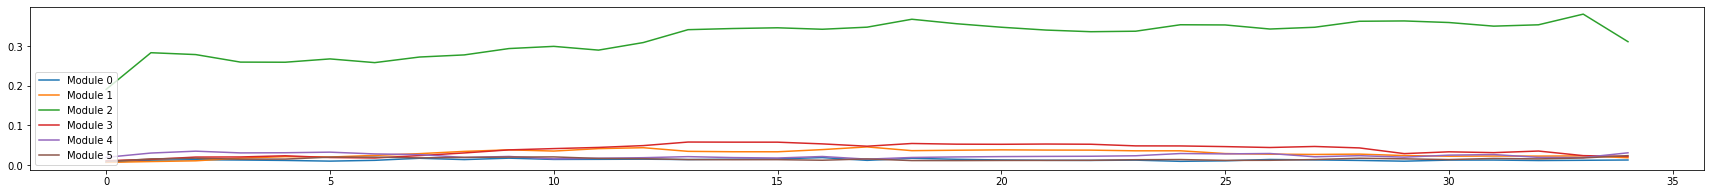

==================== pickup_sliced ====================


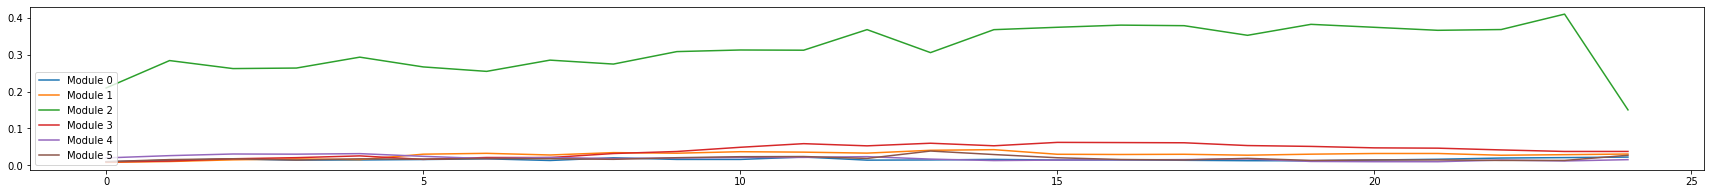

In [79]:

def normalized(x):
    return (x - x.mean())/(x.std())

def plot_sf_norms(ax, stats):
    _sf_norms = stats['sf_norms']
    

    for idx in range(_sf_norms.shape[-1]):
        sf = _sf_norms[:, idx]
        ax.plot(sf, label=f'Module {idx}')
        
        
    # ax.plot(stats['q_chosen'].max(-1), label=f'Q')

    return ax

def plot_normalized_sf_norms(ax, stats):
    _sf_norms = stats['sf_norms']

    for idx in range(mods):
        sf = _sf_norms[:, idx]
        sf = normalized(sf)
        ax.plot(sf, label=f'Module {idx}')
        
    return ax


# {'pickup': 41, 'toggle2': 43, 'pickup_sliced': 28, 'slice2': 48, 'pickup_cleaned': 35}
# intererest = data.keys()
intererest = ['slice', 'pickup_sliced']
for intr in intererest:
    # reward_episodes = {k: for k,v in data.items()}
# for k, episode in reward_episodes.items():
    print("="*20, intr, "="*20)
    

    # length, mods = _sf_norms.shape
    episode = get_rewarding_episode(data[intr])
    stats = get_episode_stats(episode=episode, config=config, norm='l2')
    # print(stats['actions'])
    height = 3
    width = 10
    fig, ax = plt.subplots(1, 1, figsize=(height*(width), height))
    ax = plot_sf_norms(ax, stats)
    
    ax.legend(loc='lower left')
    plt.show()


# Bar Plot of SF & Q

In [9]:
slice_episode = get_rewarding_episode(data['slice'])
episode_info(slice_episode)

<class 'numpy.ndarray'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
{'action': (35,),
 'interaction_info': [{},
                      {},
                      {},
                      {},
                      {},
                      {},
                      {},
                      {},
                      {},
                      {},
                      {},
                      {},
                      {},
                      {},
                      {'action': None, 'object': None},
                      {},
                      {},
                      {},
                      {},
                      {},
                      {},
                      {},
                      {},
          

In [12]:
def get_task_sfs(episode_, config_, verbosity=0):
    sf = episode_['preds'].sf[:, 0] # [T, A, D]
    w = episode_['preds'].w # [T, D]
    actions = episode_['action']

    multiply = jax.vmap(jnp.multiply, in_axes=(1, None), out_axes=1)
    
    sf_ = multiply(sf, w) # [T, A, D]
    q = sf_.sum(-1) # [T, A]
    if verbosity:
        print('multiply:', sf_.shape, '=', sf.shape, w.shape)
    sf_ = jnp.stack(jnp.split(sf_, config_['nmodules'], axis=-1), axis=2) # [T, A, N, D/N]
    if verbosity:
        print('split by module:', sf_.shape)
    sfw = sf_.sum(-1).transpose(0,2,1) # [T, A, N] --> [T, N, A]
    if verbosity:
        print('sf norms:', sfw.shape)
    
    qsf = jnp.concatenate((jnp.expand_dims(q, axis=1), sfw), axis=1)
    
    return dict(sfw=sfw, q=q, qsf=qsf)

sfdata = get_task_sfs(slice_episode, config, verbosity=1) # [T, N, A]
jax.tree_map(lambda x:x.shape, sfdata)

multiply: (35, 8, 126) = (35, 8, 126) (35, 126)
split by module: (35, 8, 6, 21)
sf norms: (35, 6, 8)


{'q': (35, 8), 'qsf': (35, 7, 8), 'sfw': (35, 6, 8)}

Figsize: (20, 4)


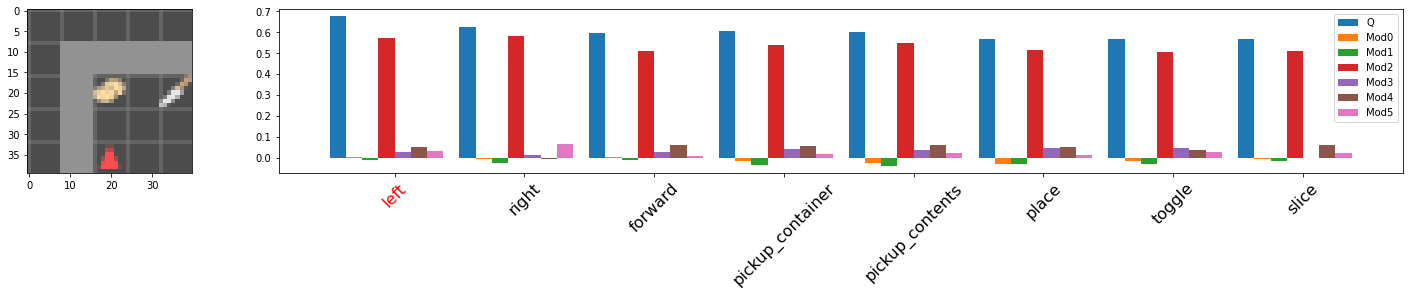

In [ ]:
fix, axs = video_tools.make_grid(
    boxes=dict(
        obs=dict(x=[0,4], y=[0,4]),
        q=dict(x=[4, 20], y=[0,4]),
    ),
)

# plot image
ims = slice_episode['observation']['image']
ax = axs['obs']
ax.imshow(ims[0])

# plot bar plot
ax = axs['q']
N = config['nmodules']+1
width = 1/(N+1)

y = sfdata['qsf'] # [T, N, A]
A = y.shape[-1]
x = np.arange(A)
for idx in range(N):
    label = 'Q' if idx == 0 else f"Mod{idx-1}"
    ax.bar(x + width*(idx) - (width*N/2), y[0, idx], width, label=label)

rotation=45
tick_text_size=16
names = ['left', 'right', 'forward', 'pickup_container', 'pickup_contents', 'place', 'toggle', 'slice']
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=rotation, fontsize=tick_text_size)
ax.legend()


chosen_action = slice_episode['action'][0]
ax.get_xticklabels()[chosen_action].set_color('red')

plt.show()

# Plotting agreement

Figsize: (33, 4)
29 29


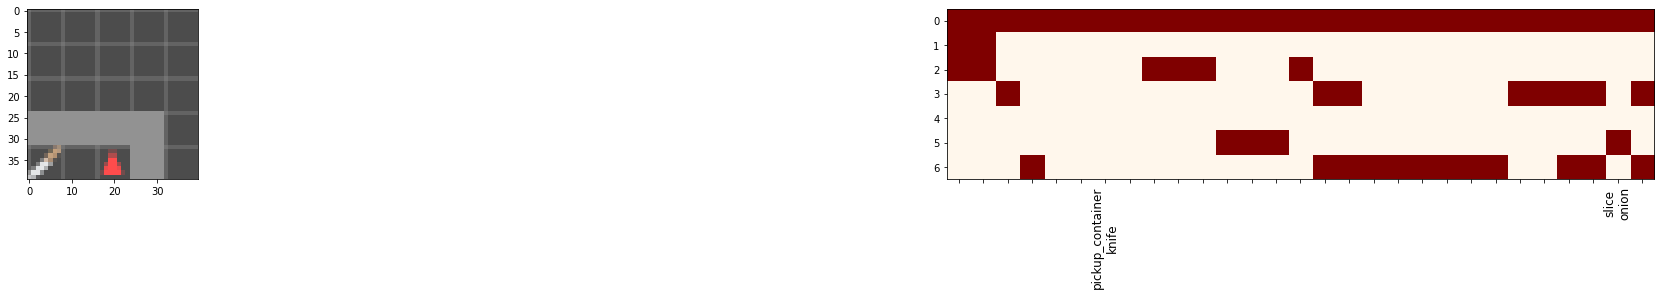

In [113]:
slice_episode = get_rewarding_episode(data['slice'])

def interaction_labels(ep_):
    info = ep_['interaction_info']
    labels = []
    for i in info:
        if i:
            label = f"{i['action']}\n{i['object']}"
        else:
            label = ''
        labels.append(label)
    return labels



ims = slice_episode['observation']['image']
sfdata = get_task_sfs(slice_episode, config, verbosity=0) # [T, N, A]
actions = slice_episode['action']

fix, axs = video_tools.make_grid(
    boxes=dict(
        obs=dict(x=[0,4], y=[0,4]),
        q=dict(x=[4, 4+len(ims)], y=[0,4]),
    ),
)

tdx=0
# plot image

ax = axs['obs']
ax.imshow(ims[tdx])

# plot bar plot
ax = axs['q']
agree = lambda a,b: a == b 
agreement = jax.vmap(agree, in_axes=(None, 1), out_axes=1)(actions, sfdata['qsf'].argmax(-1))


# ax.imshow(jnp.expand_dims(agreement[tdx], 1), cmap = 'bwr' , interpolation = 'nearest')
ax.imshow(agreement.T, cmap = 'OrRd' , interpolation = 'nearest')


minor_fs=12
labels = interaction_labels(slice_episode)
print(len(labels), len(agreement))
ax.set_xticks(np.arange(len(labels)), labels=labels, rotation=90, fontsize=minor_fs)

plt.show()

In [100]:
ims.shape, slice_episode['rewards'].shape, len(slice_episode['interaction_info'])

((18, 40, 40, 3), (18,), 18)

==================== toggle2 ====================
Figsize: (53, 4)


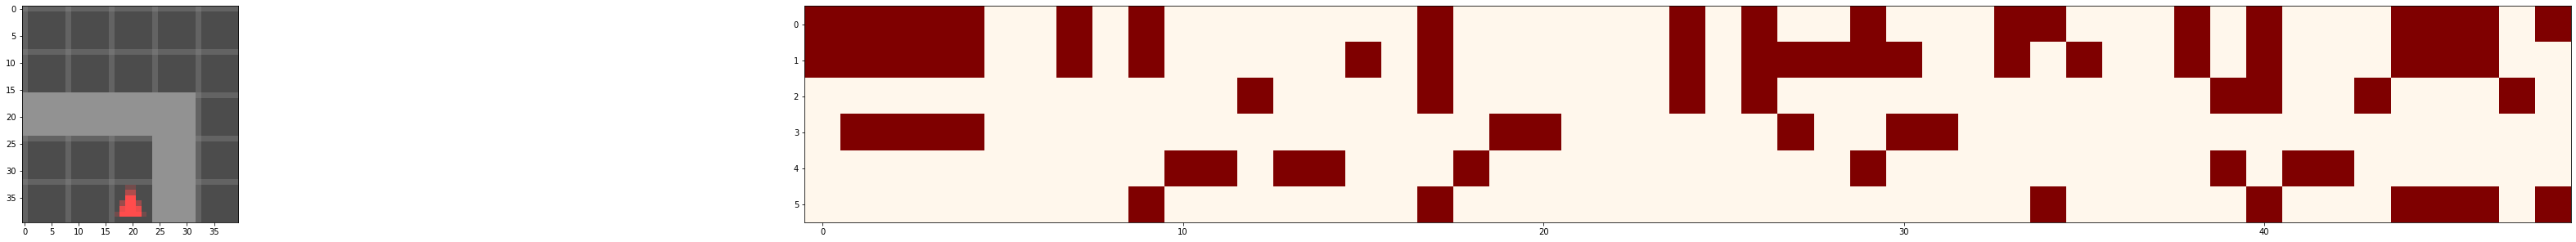

==================== slice ====================
Figsize: (16, 4)


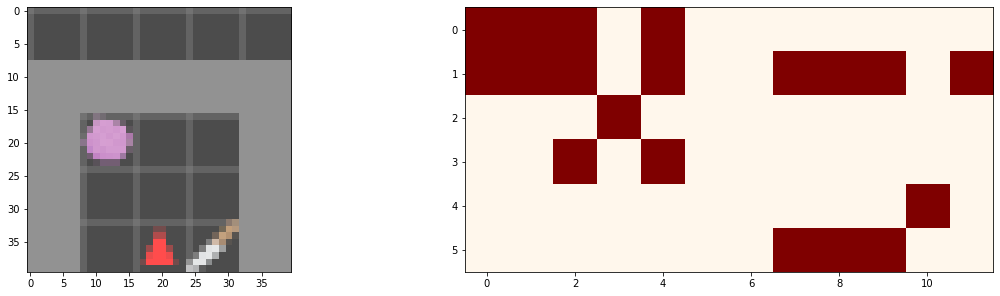

==================== pickup_sliced ====================
Figsize: (37, 4)


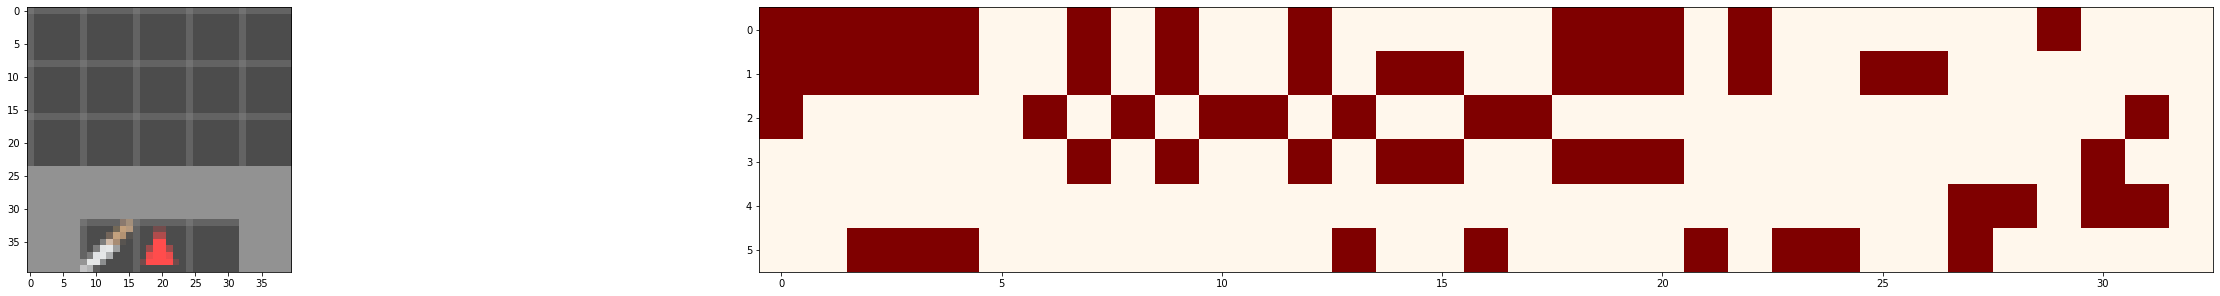

In [85]:
intererest = ['toggle2', 'slice', 'pickup_sliced']
for intr in intererest:
    print("="*20, intr, "="*20)
    

    # length, mods = _sf_norms.shape
    episode = get_rewarding_episode(data[intr])

    ims = episode['observation']['image']
    sfdata = get_task_sfs(episode, config, verbosity=0) # [T, N, A]
    actions = episode['action']

    fix, axs = video_tools.make_grid(
        boxes=dict(
            obs=dict(x=[0,4], y=[0,4]),
            q=dict(x=[4, 4+len(ims)], y=[0,4]),
        ),
    )

    tdx=0
    # plot image

    ax = axs['obs']
    ax.imshow(ims[tdx])

    # plot bar plot
    ax = axs['q']
    agree = lambda a,b: a == b 
    agreement = jax.vmap(agree, in_axes=(None, 1), out_axes=1)(actions, sfdata['sfw'].argmax(-1))
    # ax.imshow(jnp.expand_dims(agreement[tdx], 1), cmap = 'bwr' , interpolation = 'nearest')
    ax.imshow(agreement.T, cmap = 'OrRd' , interpolation = 'nearest')
    plt.show()
    break

# Visualizing norm of hidden

(35, 6)


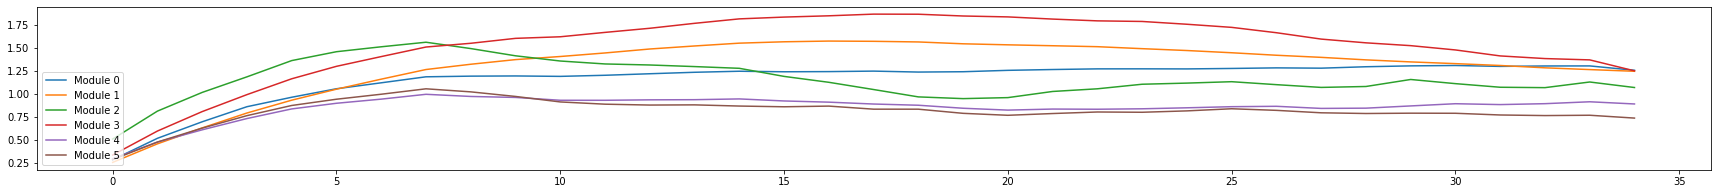

In [46]:
episode = slice_episode
episode.keys()
lstm_state = episode['lstm_state']
hidden = lstm_state.hidden
hidden.shape
norms = jnp.linalg.norm(hidden, 2, axis=-1)
print(norms.shape)

height = 3
width = 10
fig, ax = plt.subplots(1, 1, figsize=(height*(width), height))

for idx in range(norms.shape[-1]):
    h = norms[:, idx]
    ax.plot(h, label=f'Module {idx}')
ax.legend(loc='lower left')
plt.show()